# Tutorial 7b - Adversarial Examples

This notebook demonstrates how easy it is to create adversarial examples.
Let's start by training some models to classify the digits in the
MNIST data set. We'll work with one fully-connected neural network
and one convolutional network to show the generality of our approach.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

mnist_images = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5, padding=2)
        self.fc1 = nn.Linear(10 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!






In [2]:
def train(model, data, batch_size=64, lr=0.001, num_iters=1000, print_every=100): 
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    n = 0

    while True:
        for imgs, labels in iter(train_loader):
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            n += 1
        
            if n % print_every == 0:
                print("Iter %d. Avg.Loss: %f" % (n, total_loss/print_every))
                total_loss = 0
            if n > num_iters:
                return

In [3]:
fc_model = FCNet()
train(fc_model, mnist_images, num_iters=1000)

Iter 100. Avg.Loss: 1.552247
Iter 200. Avg.Loss: 0.642676
Iter 300. Avg.Loss: 0.513709
Iter 400. Avg.Loss: 0.396096
Iter 500. Avg.Loss: 0.389637
Iter 600. Avg.Loss: 0.338732
Iter 700. Avg.Loss: 0.339028
Iter 800. Avg.Loss: 0.338941
Iter 900. Avg.Loss: 0.276824
Iter 1000. Avg.Loss: 0.233706


In [4]:
cnn_model = ConvNet()
train(cnn_model, mnist_images, num_iters=1000)

Iter 100. Avg.Loss: 1.387515
Iter 200. Avg.Loss: 0.541140
Iter 300. Avg.Loss: 0.392721
Iter 400. Avg.Loss: 0.286566
Iter 500. Avg.Loss: 0.278528
Iter 600. Avg.Loss: 0.236316
Iter 700. Avg.Loss: 0.222587
Iter 800. Avg.Loss: 0.214486
Iter 900. Avg.Loss: 0.161610
Iter 1000. Avg.Loss: 0.124340


## Targetted Adversarial Attack

The purpose of an adversarial attack is to perturb an input 
(usually an image $x$) so that a neural network $f$ misclassifies
the perturbed image $x + \epsilon$. In a targeted attack, we
want the network $f$ to misclassify the perturbed image into
a class of our choosing.

Let's begin with this image. We will perturb the image so our model
thinks that the image is of the digit 3, when in fact it is of the
digit 5.

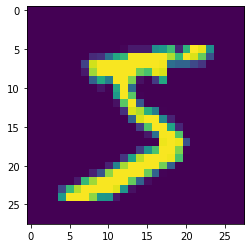

In [5]:
image = mnist_images[0][0]
target_label = 3
model = fc_model

plt.imshow(image[0])

Our approach is as follows:

- We will create a random noise $\epsilon$ that is the same size 
  as the image.
- We will use an optimizer to tune the values of $\epsilon$ to
  make the neural network misclassify $x + \epsilon$ to our target class

The second step might sound a little mysterious, but is actually
very similar to tuning the weights of a neural network!

First, let's create some noise values. In order for PyTorch to be
able to tune these values using an optimizer, we need to
set `requires_grad=True`:

In [6]:
noise = torch.randn(1, 28, 28) * 0.01
noise.requires_grad = True

Now, we will tune the noise:

In [7]:
optimizer = optim.Adam([noise], lr=0.01, weight_decay=1)
criterion = nn.CrossEntropyLoss()

for i in range(1000):
    adv_image = torch.clamp(image + noise, 0, 1)
    out = model(adv_image.unsqueeze(0))
    loss = criterion(out, torch.Tensor([target_label]).long())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

To keep the pixel values in `noise` small,
we use a fairly large `weight_decay`. We use the `CrossEntropyLoss`,
but maximize the neural network prediction of our `target_label`.

Notice also that the `adv_image` is clamped so that the pixel values
are kept in the range [0, 1].

Now, let's see the resulting image:

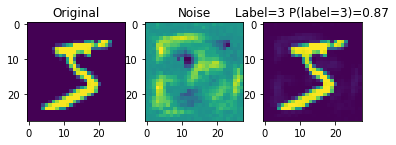

In [8]:
adv_image = torch.clamp(image + noise, 0, 1)
adv_label = torch.argmax(model(adv_image), dim=1).item()
adv_percent = torch.softmax(model(adv_image), dim=1)[0,target_label].item()

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image[0])

plt.subplot(1, 3, 2)
plt.title("Noise")
plt.imshow(noise[0].detach().numpy())

plt.subplot(1, 3, 3)
plt.title("Label=%d P(label=%d)=%.2f" % (adv_label, target_label, adv_percent))
plt.imshow(adv_image.detach().numpy()[0])

The image on the right still looks like a "5" to a human.
However, the neural network misclassifies the image.

The same steps can be used to create an adversarial attack
for other images, and for other model architectures.

In [9]:
def create_adversarial_example(model, image, target_label):
    noise = torch.randn(1, 28, 28)
    noise.requires_grad = True
    
    optimizer = optim.Adam([noise], lr=0.01, weight_decay=1)
    criterion = nn.CrossEntropyLoss()

    for i in range(1000):
        adv_image = torch.clamp(image + noise, 0, 1)
        out = model(adv_image.unsqueeze(0))
        loss = criterion(out, torch.Tensor([target_label]).long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  
    adv_image = torch.clamp(image + noise, 0, 1)
    adv_label = torch.argmax(model(adv_image.unsqueeze(0)), dim=1).item()
    adv_percent = torch.softmax(model(adv_image.unsqueeze(0)), dim=1)[0,target_label].item()

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image[0])
    
    plt.subplot(1, 3, 2)
    plt.title("Noise")
    plt.imshow(noise[0].detach().numpy())
    
    plt.subplot(1, 3, 3)
    plt.title("Label=%d P(label=%d)=%.2f" % (adv_label, target_label, adv_percent))
    plt.imshow(adv_image.detach().numpy()[0])

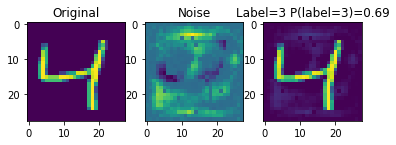

In [10]:
create_adversarial_example(fc_model, mnist_images[2][0], 3)

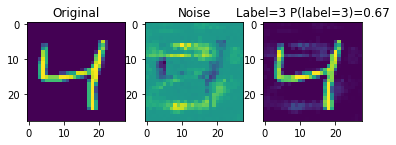

In [11]:
create_adversarial_example(cnn_model, mnist_images[2][0], 3)

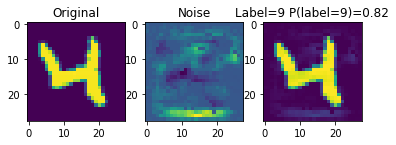

In [12]:
create_adversarial_example(fc_model, mnist_images[20][0], 9)

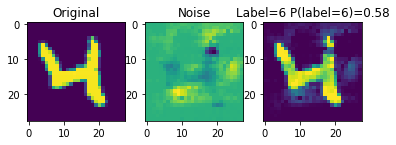

In [13]:
create_adversarial_example(cnn_model, mnist_images[20][0], 6)